# Compound Floods: Coastal

## TODO
- add relations with tide types
- Use monthly median and daily mean
- Check if tide threshold changes overtime
- Check extremes

**Converted all to daily to match cmip6 --> daily max/mean from hourly and original cmip6**

#### Hourly observational data
- Max/mean Wind Data (m/s) from noaa
- Max/mean Tides and Water Level (m) from noaa
- True hourly wind speed, direction, precip from meteostat

#### CMIP6 only using ssp 245
- sfcwind: LARC_sfcWind_historical_daily.csv, LARC_sfcWind_ssp245_daily.csv
- pr: LARC_pr_historical_daily.csv, LARC_pr_ssp126_daily.csv, LARC_pr_ssp245_daily.csv, LARC_pr_ssp370_daily.csv

### Modifications and Assumptions
**General**
- Rows with less than n observations per year were removed
- Only 1950 and after

**Wind**
- wind direction degree [0, 360]
- wind gust >= speed >= 0
- Extremes: max speed and gust in 1 hour (based on 6 minute intervals)
- Circular mean wind direction (max mode for text version)

**Tides**
- MHHW and MSL are most indicative of flood risks
- high_low tides (HH, H, L, LL) are all the same across MHHW, MHW, MSL… → only processed MSL to get labeled dates
- Value - Measured water level height for product='high_low' and product='water_level' for the same datum are different → use values in water_level
- Sigma - Standard deviation of 1 second samples used to compute the water level height; **sigma > 3** is considered bad quality and removed


<details>
<summary> NOAA Tides & Currents: mean in past time interval </summary>
    
- Virginia: https://tidesandcurrents.noaa.gov/map/index.html?region=Virginia#
- Yorktown: https://tidesandcurrents.noaa.gov/inventory.html?id=8637689
- Sewells Point: https://tidesandcurrents.noaa.gov/inventory.html?id=8638610
- Gloucester before 2003: https://tidesandcurrents.noaa.gov/inventory.html?id=8637624
- https://pypi.org/project/noaa-coops/
- product: https://api.tidesandcurrents.noaa.gov/api/prod/#products
- datum: https://api.tidesandcurrents.noaa.gov/api/prod/#datum:~:text=for%20the%20station-,Datum,-The%20datum%20can
- Output columns: https://api.tidesandcurrents.noaa.gov/api/prod/responseHelp.html
- https://maps.waterdata.usgs.gov/mapper/index.html
- dates of active stations are from (first available day) to (at most day of download)
</details>

<details>
<summary> Meteostat: measurements at end of each hour </summary>
    
- https://dev.meteostat.net/python/daily.html#data-structure
- Variables and units: https://dev.meteostat.net/formats.html
- Station data columns: https://dev.meteostat.net/python/stations.html#data-structure
</details>

<details>
<summary> 2016 Floods </summary>
    
- September 2-3, 2016 Tropical Storm Hermine https://www.weather.gov/mhx/hermine_090216
- September 11 – 23, 2016: Tropical Storm Julia https://www.wpc.ncep.noaa.gov/tropical/rain/julia2016.html
- October 8, 2016: Hurricane Matthew https://www.weather.gov/ilm/matthew
</details>

In [1]:
# !pip install noaa_coops
# !pip install meteostat

import os
import re
import glob
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.colors import qualitative
from plotly.subplots import make_subplots
import geopandas as gpd
from shapely.geometry import Point, box
import contextily as cx
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from IPython.display import Image, display
import plot_settings

warnings.filterwarnings('ignore')

static = True # interactive/static plotly plots
PATH = 'data/flood_dailymean' # flood_dailymax
# !python process_flood.py --output_dir $PATH

# Load Data

In [2]:
# Load NOAA and Meteo
noaa = pd.read_csv(f'{PATH}/noaa_tc.csv')
noaa['station_id'] = noaa.station_id.astype(str)
noaa[['start_date', 'end_date']] = noaa[['start_date', 'end_date']].apply(pd.to_datetime)
noaa['station'] = noaa.station_name + ' ' + noaa.station_id
wind_stations = noaa.loc[noaa.variable == 'Wind', 'station_id'].values
water_stations = noaa.loc[noaa.variable == 'Verified 6-Minute Water Level', 'station_id'].values

meteo = pd.read_csv(f'{PATH}/meteo.csv').rename(columns={'latitude': 'lat', 'longitude': 'lon'})
meteo[['hourly_start', 'hourly_end']] = meteo[['hourly_start', 'hourly_end']].apply(pd.to_datetime)
meteo['station'] = meteo.name + ' ' + meteo.id

# Load DataFrames
wind_df = pd.read_parquet(f'{PATH}/noaa_tc.wind.parquet')
wind_df = wind_df.loc[:, ~wind_df.columns.str.contains('flag')]
water_df = pd.read_parquet(f'{PATH}/noaa_tc.water.parquet')
meteo_df = pd.read_parquet(f'{PATH}/meteo.pr_wind.parquet')
cmip_df = pd.read_parquet(f'{PATH}/cmip.pr_wind.parquet').query("scenario in ['historical', 'ssp245']")
cmip_df.index = cmip_df.index.droplevel('scenario')
cmip_df.columns = cmip_df.columns.str.replace('sfcwind_', 'speed_', regex=False)

# Join all data
cmip_models = '|'.join(re.escape(col.split('_')[1]) for col in cmip_df.columns)
df = pd.concat([wind_df, water_df, meteo_df, cmip_df], axis=1)
df = df[sorted(df.columns)][df.index.year >= 1950]

# Remove sparse years
def mask_sparse_years(df, min_obs=100):
    '''Set all values in a year to nan if that year does not have at least min_obs values'''
    sparse_mask = df.notna().groupby(df.index.year).sum() < min_obs
    year_index = df.index.year.values
    mask = np.zeros_like(df.values, dtype=bool)
    for col_idx, col in enumerate(df.columns):
        for year_idx, year in enumerate(sparse_mask.index):
            if sparse_mask.iloc[year_idx, col_idx]:
                mask[year_index == year, col_idx] = True
    return df.mask(mask)

df = mask_sparse_years(df)
no_cmip_df = df[[col for col in df.columns if not re.search(cmip_models, col)]].dropna(how='all')

# Variables map
var_map = {
    'speed_': 'Wind Speed (m/s)',
    'gust_': 'Wind Gust (m/s)',
    'mhhw_|msl_': 'Mean Higher High Water and Mean Sea Level (m)',
    'mhhw_': 'Mean Higher High Water(m)',
    'msl_': 'Mean Sea Level (m)',
    'pr_': 'Precipitation (mm)',
    'dir_': 'Wind Direction',
    'dirdeg_': 'Wind Direction (degree)',
    'type_': 'Tide Type (LL-1, L-2, H-3, HH-4)'
}

# Stations with color
color_list = px.colors.qualitative.Plotly + px.colors.qualitative.Light24 + px.colors.qualitative.Alphabet
colors = {}
for sid, name in sorted(
    list(zip(noaa['station_id'].astype(str), noaa['station_name'])) +
    list(zip(meteo['id'], meteo['name'])) +
    [(col.split('_')[1], None) for col in cmip_df.columns]
):
    colors.setdefault(sid, {'name': name or sid, 'color': color_list[len(colors)]})
colors = pd.DataFrame.from_dict(colors, orient='index').reset_index().rename(columns={'index': 'id'})
tide_map = {1: 'LL', 2: 'L', 3: 'H', 4: 'HH'}

# Exploratory Data Analysis
## Station Map

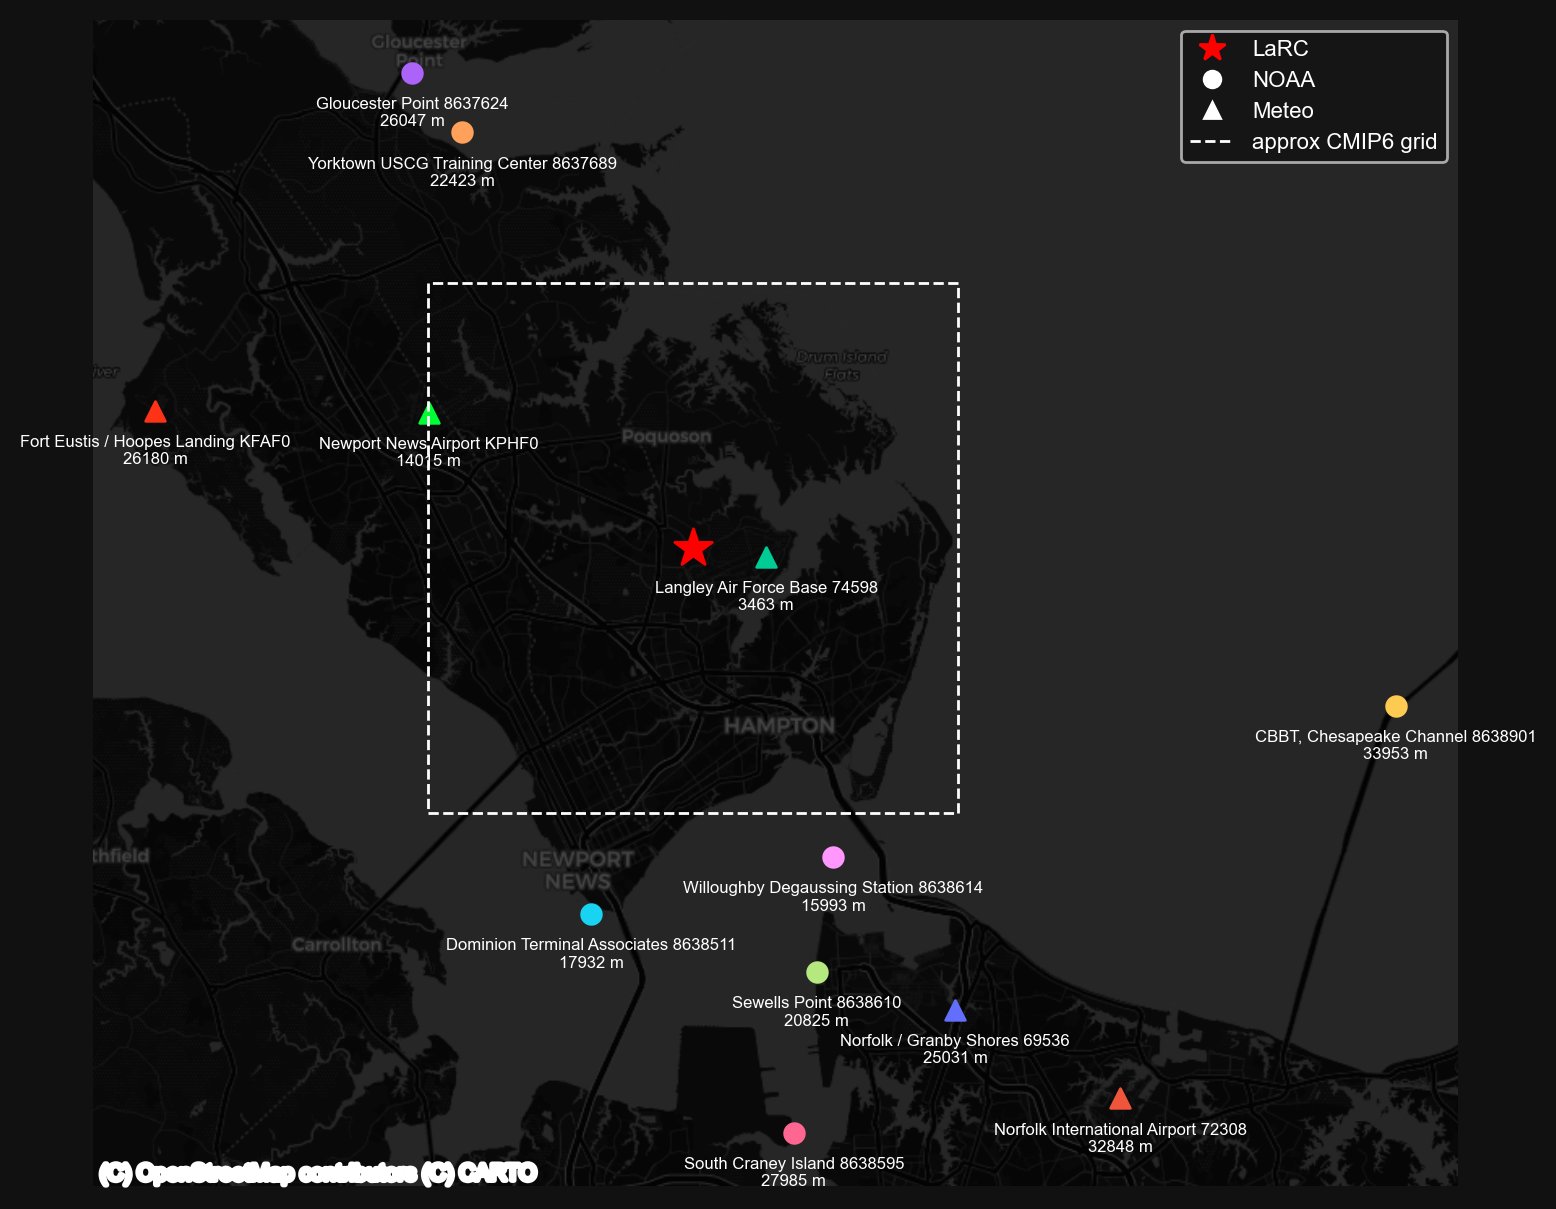

In [3]:
# Station Map
ref = gpd.GeoSeries([Point(-76.3809, 37.0862)], crs='EPSG:4326').to_crs(3857)
buffer = 12_500 # 12.5 km each direction for a 25x25 km box for cmip6
x, y = ref.geometry[0].x, ref.geometry[0].y
bbox = gpd.GeoSeries([box(x - buffer, y - buffer, x + buffer, y + buffer)], crs='EPSG:3857')

fig, ax = plt.subplots(figsize=(8, 8), dpi=200)

for dd, id_col, label, marker in [(noaa, 'station_id', 'NOAA', 'o'), (meteo, 'id', 'Meteo', '^')]:
    gdf = gpd.GeoDataFrame(dd, geometry=gpd.points_from_xy(dd.lon, dd.lat), crs='EPSG:4326').to_crs(3857)
    gdf = gdf.drop_duplicates(subset=[id_col, 'lat', 'lon'])
    gdf['distance'] = gdf.geometry.distance(ref[0])
    for _, r in gdf.iterrows():
        ax.scatter(r.geometry.x, r.geometry.y, s=50, color=colors[colors.id==str(r[id_col])]['color'], marker=marker)
        ax.text(r.geometry.x, r.geometry.y - 2500, f'{r.station}\n{r.distance:.0f} m', fontsize=6, ha='center')

ref.plot(ax=ax, color='red', marker='*', markersize=200, label='LaRC')
bbox.boundary.plot(ax=ax, color='white', linewidth=1, linestyle='--')
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)
ax.set_axis_off()

ax.legend(handles=[
    mlines.Line2D([], [], color='red', marker='*', linestyle='None', markersize=10, label='LaRC'),
    mlines.Line2D([], [], color='white', marker='o', linestyle='None', markersize=6, label='NOAA'),
    mlines.Line2D([], [], color='white', marker='^', linestyle='None', markersize=6, label='Meteo'),
    mlines.Line2D([], [], color='white', linestyle='--', linewidth=1, label='approx CMIP6 grid')
], fontsize=8)

plt.tight_layout()
plt.show()


## Time Interval
Might have date gaps between start and end date

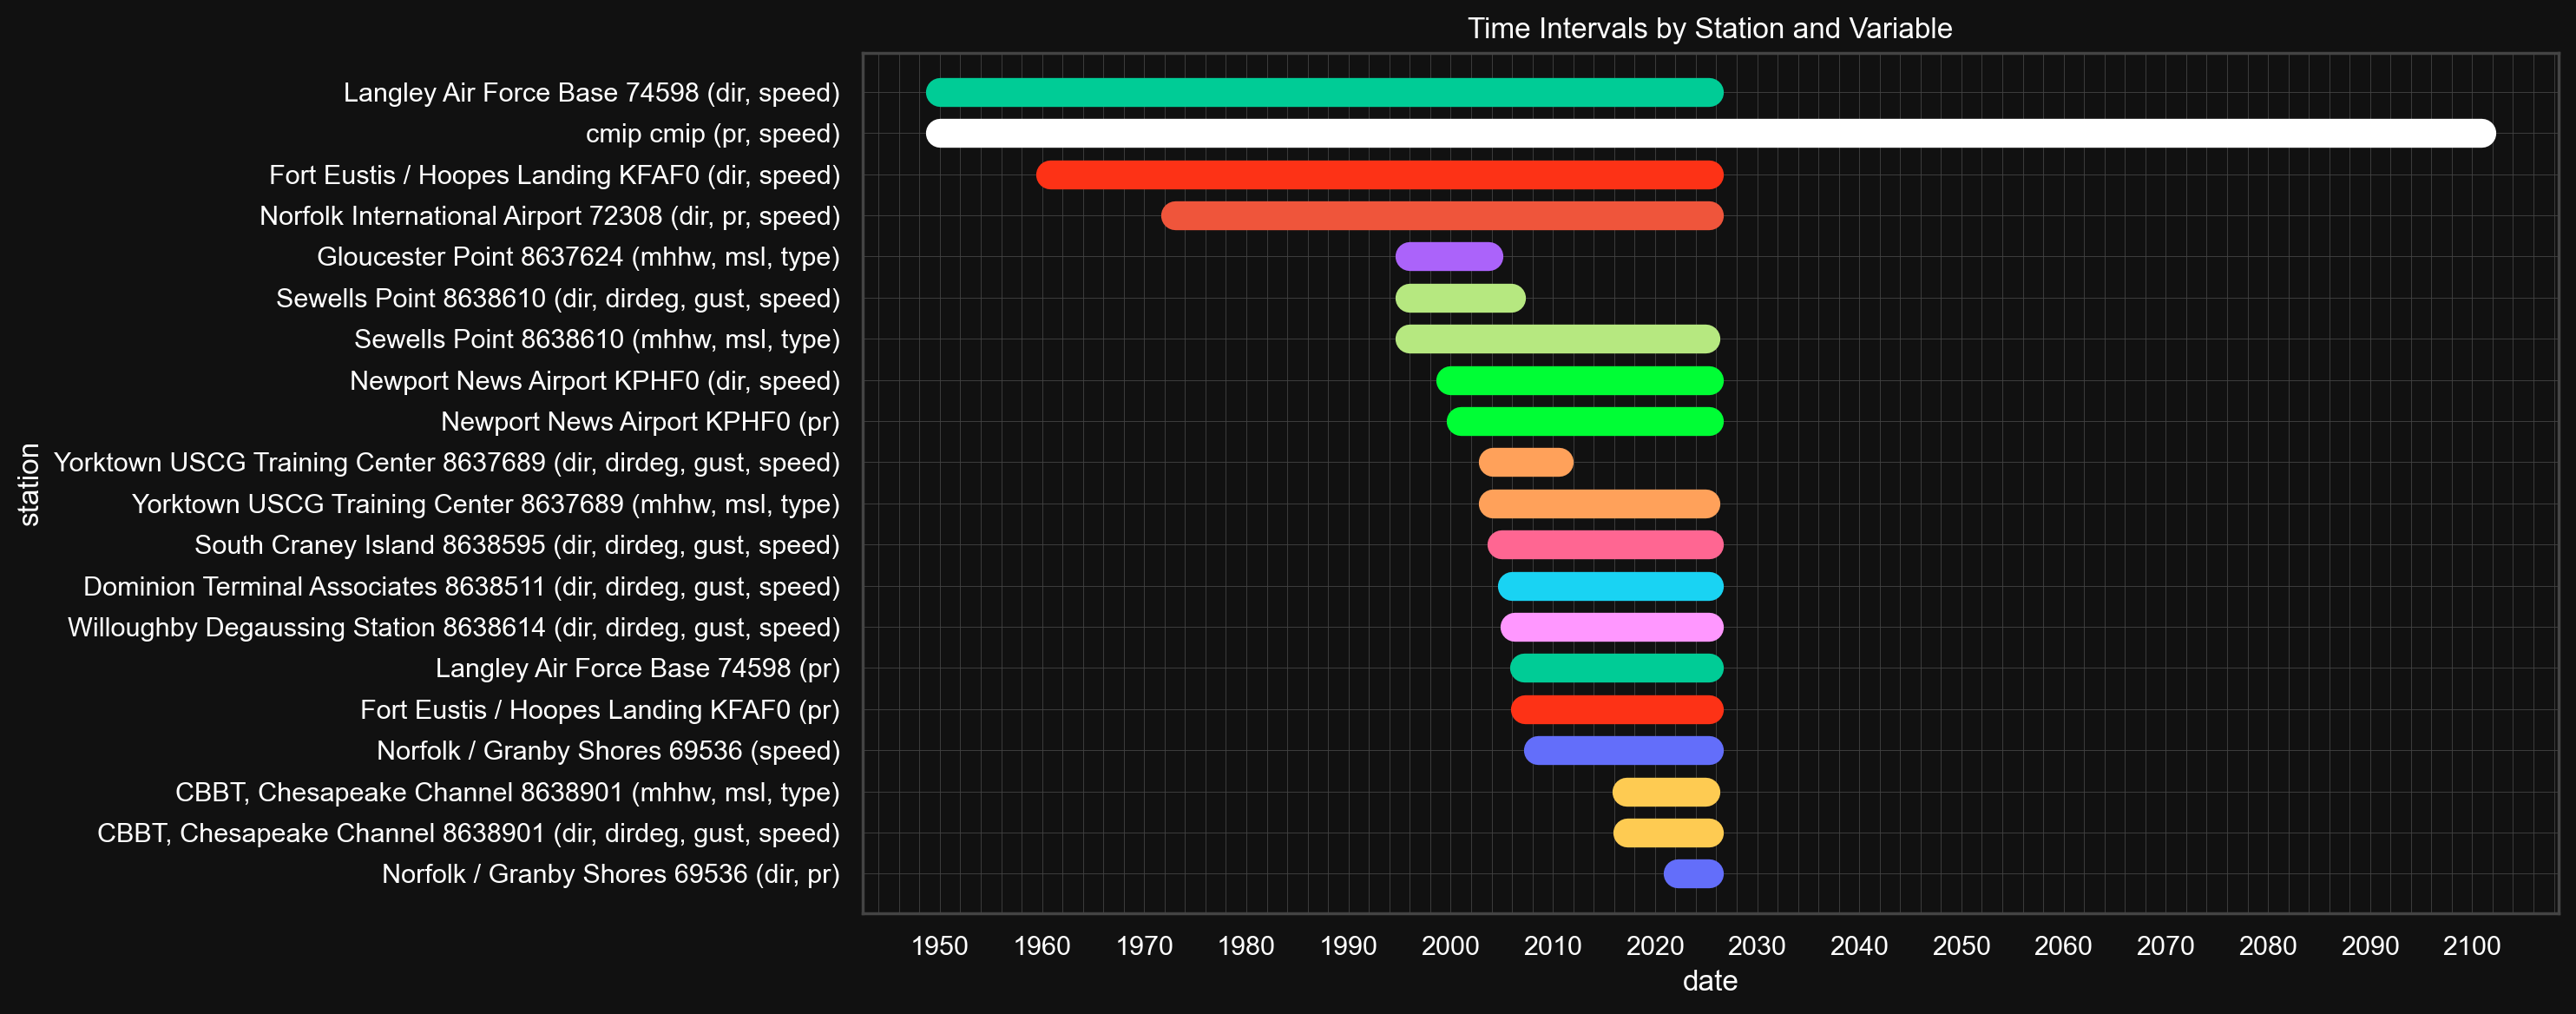

In [4]:
def get_time_intervals(df):
    res = pd.DataFrame([{'prefix': p, 'station': s, 'start_date': vals.index.min(), 'end_date': vals.index.max()}
                        for c in df.columns if not (vals := df[c].dropna()).empty for p, s in [c.split('_', 1)]])
    res[['start_date', 'end_date']] = res[['start_date', 'end_date']].apply(lambda x: x.dt.strftime('%Y-%m'))
    res = res.groupby(['station', 'start_date', 'end_date']).agg(lambda x: ', '.join(sorted(set(x)))).reset_index()
    res = res.merge(colors, left_on='station', right_on='id', how='left')

    res['station'] = res['name'] + ' ' + res['id'] + ' (' + res['prefix'] + ')'
    return res.sort_values(['start_date', 'station'])
    
def plot_time_intervals(df, title=None):
    df = df.melt(id_vars=['station', 'prefix', 'color'], value_vars=['start_date', 'end_date'],
                 var_name='type', value_name='date')
    df.date = pd.to_datetime(df.date)
    df.station = df.station.str.replace(cmip_models, 'cmip', regex=True)
    df = df.drop_duplicates()

    palette = dict(zip(df.station, df.color))
    cmip_mask = df['station'].str.contains('cmip', regex=False)
    palette.update({s: 'white' for s in df[cmip_mask]['station']})

    plt.figure(figsize=(15, 6))
    ax = sns.lineplot(data=df, x='date', y='station', hue='station', lw=12, legend=False, palette=palette)
    ax.set(title=title)
    ax.xaxis.set_minor_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', which='minor', length=0)
    ax.grid(which='both', linewidth=0.3)
    plt.tight_layout()
    plt.show()

plot_time_intervals(get_time_intervals(df), title='Time Intervals by Station and Variable')

## Correlation Matrix
#### Observed data across all stations
- High correlation (near 1) between mean higher high water (mhhw) and mean sea level (msl)
- Moderate to high correlation between wind speed and gust
- Low correlation between (mhhw, msl) and (wind speed, gust)

#### CMIP6 data across all models
- Low correlation between precipitation
- Low correlation between surface wind
- Low correlation with observed data (precip, wind speed)

#### Choose variables
- Use one of mhhw and msl $\rightarrow$ **tbd**
- Use one of wind speed and gust $\rightarrow$ **speed**

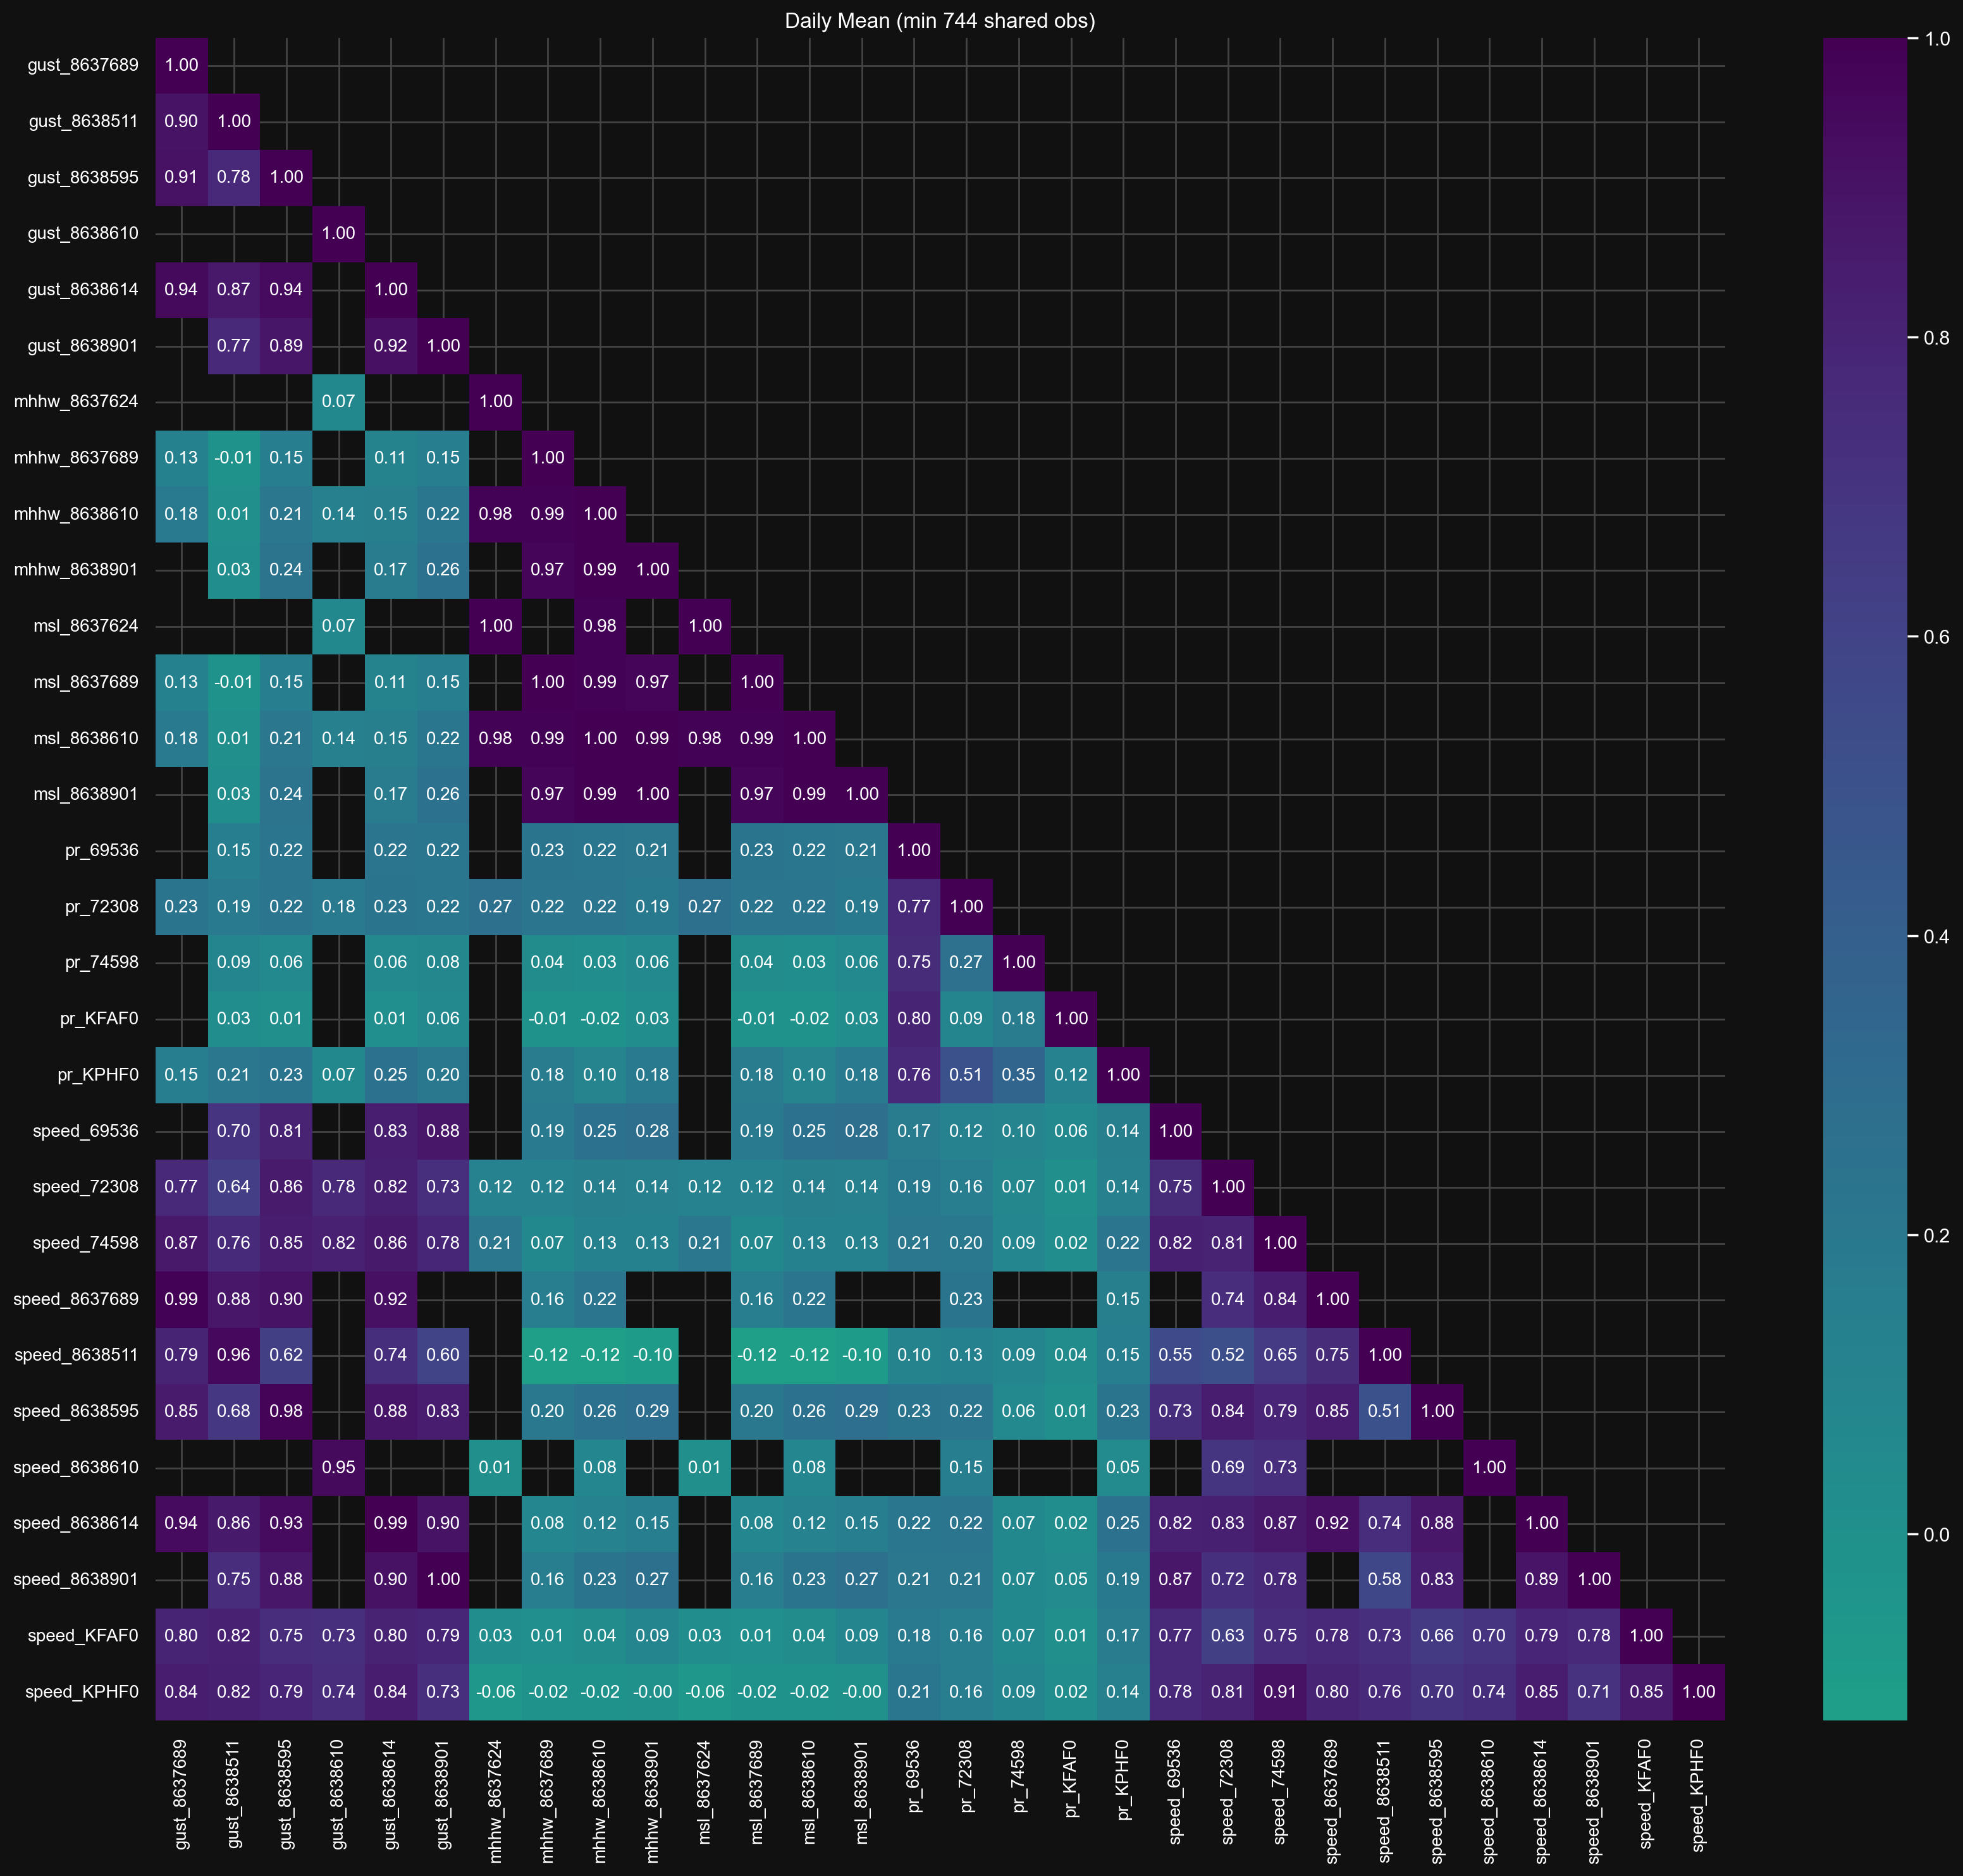

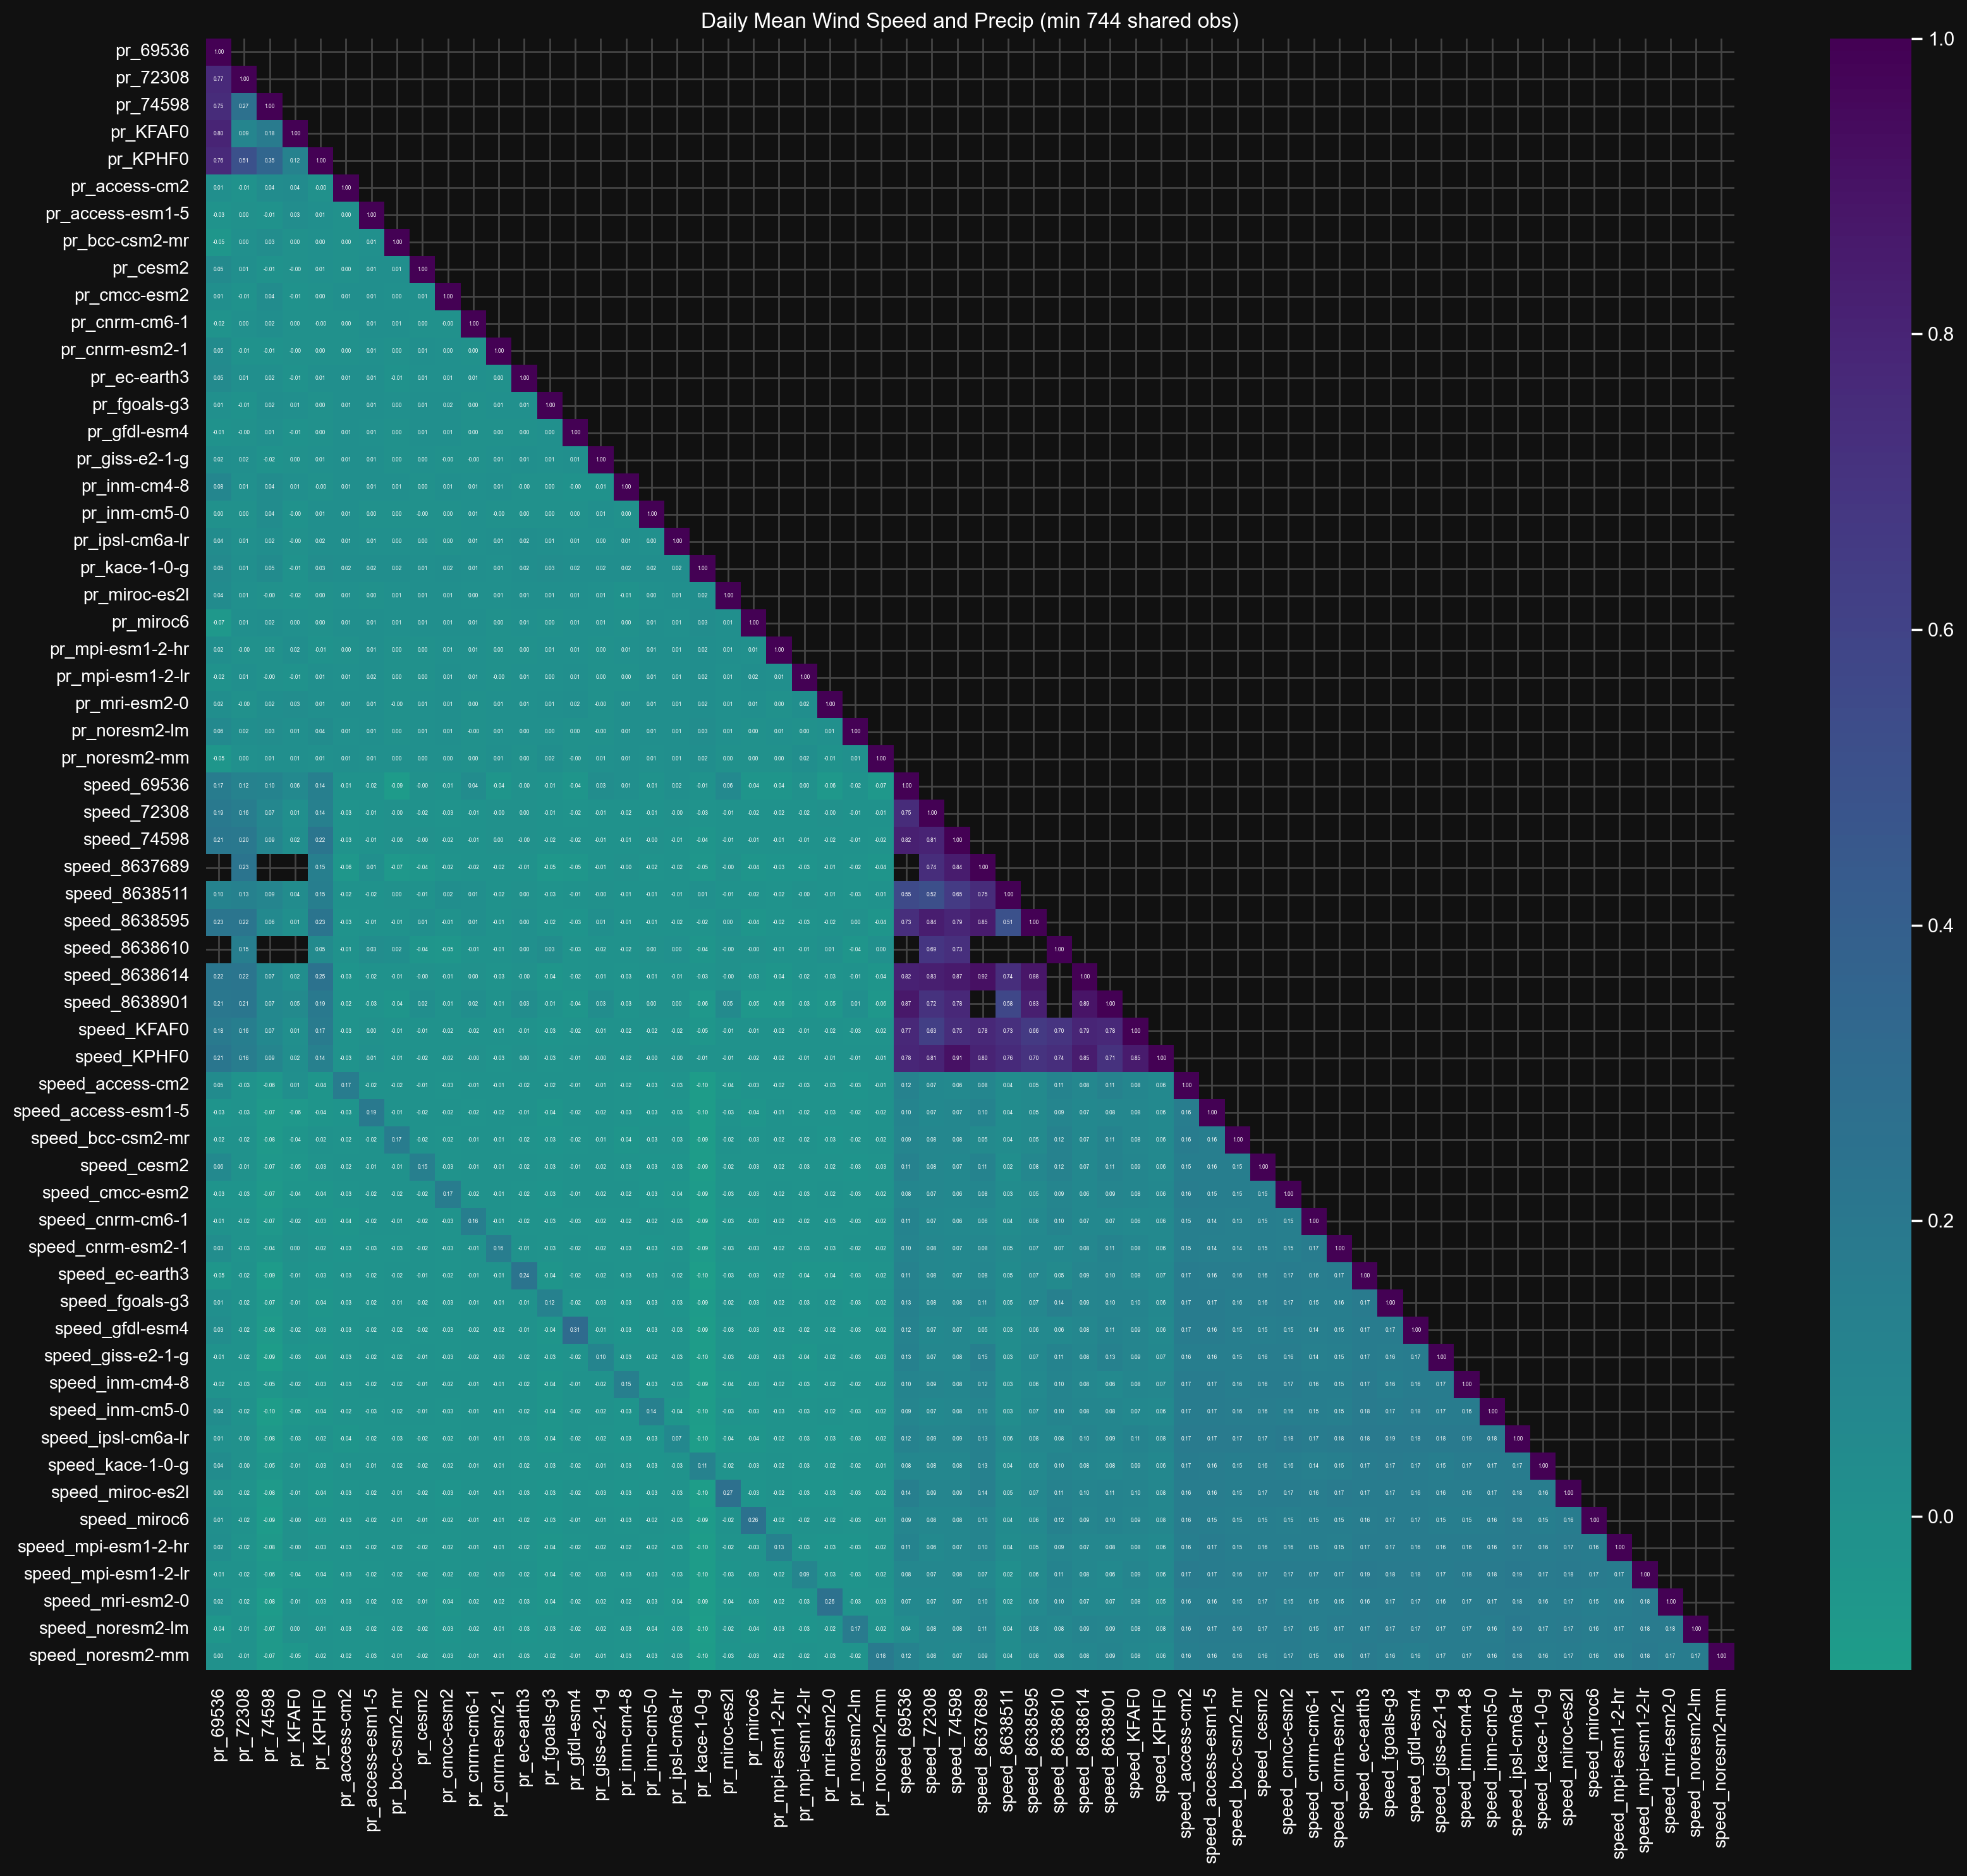

In [5]:
def plot_corr(df, title, res='h', min_shared=100, fmt='.2f', center=0, annot_size=10, label_size=10):
    resampled = df.resample(res).mean()
    non_na_counts = (~resampled.isna()).astype(int)
    shared_obs = non_na_counts.T @ non_na_counts
    insufficient_obs = shared_obs < min_shared
    corr = resampled.corr()
    corr = corr.mask(insufficient_obs)
    plt.figure(figsize=(17, 15))
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    sns.heatmap(corr, mask=mask, annot=True, fmt=fmt, cmap='viridis_r', 
                center=center, annot_kws={'size': annot_size})
    plt.title(f'{title} (min {min_shared} shared obs)')
    plt.xticks(fontsize=label_size) 
    plt.yticks(fontsize=label_size)
    plt.tight_layout()
    plt.show()

filtered = no_cmip_df.filter(regex=r'speed_|gust_|msl_|mhhw_|pr_')
# plot_corr(filtered, 'Hourly', res='h', min_shared=24*31*12)
plot_corr(filtered, 'Daily Mean', res='d', min_shared=31*12*2)
plot_corr(df.filter(regex=r'speed_|pr_'), 'Daily Mean Wind Speed and Precip', res='d', min_shared=31*12*2, annot_size=3)
# plot_corr(filtered, 'Monthly Max', res='ME', min_shared=12*3)

## Monthly Means Time Series
- increase in msl and mhhw
- decrease in pr but extremes in KFAF0 and KPHF0; can't see 72308

In [6]:
print('STANDARD DEVIATION SUMMARY: Variability across stations vs CMIP6 models by variable group per day')
var_groups = ['speed_', 'gust_', 'mhhw_|msl_', 'pr_']
methods = {'daily': lambda df: df.resample('d').mean().std(axis=1).dropna(),
          # 'monthly_max': lambda df: df.resample('ME').max().std(axis=1).dropna(),
          # 'monthly_mean': lambda df: df.resample('ME').mean().std(axis=1).dropna(),
          # 'monthly_med': lambda df: df.resample('ME').median().std(axis=1).dropna()
          }

def get_variability(df, source_name):
   return pd.concat({f"{source_name}_{method}": pd.DataFrame({
       var: func(df.filter(regex=var)).describe() for var in var_groups
   }).T for method, func in methods.items()}, axis=0).dropna()

result = pd.concat([get_variability(no_cmip_df, "stations"), get_variability(cmip_df, "cmip6"), 
                    get_variability(df.filter(regex='speed_|pr_'), "all")])

display(result.sort_values('mean', ascending=False))

STANDARD DEVIATION SUMMARY: Variability across stations vs CMIP6 models by variable group per day


count      mean       std           min  \
cmip6_daily    pr_         55152.0  5.948547  2.866051  3.676652e-02   
all_daily      pr_         55152.0  5.895657  2.849170  3.676652e-02   
               speed_      55152.0  1.494900  0.389653  5.073258e-01   
cmip6_daily    speed_      55152.0  1.474871  0.383700  4.725949e-01   
stations_daily speed_      22824.0  1.031360  0.585816  1.570092e-16   
               gust_        7701.0  0.890779  0.611135  7.162361e-03   
               pr_          7927.0  0.406079  2.491024  0.000000e+00   
               mhhw_|msl_  10592.0  0.244582  0.008603  2.389283e-01   

                                25%       50%       75%         max  
cmip6_daily    pr_         4.067672  5.370054  7.180270   27.397052  
all_daily      pr_         4.029488  5.323259  7.114644   42.781744  
               speed_      1.183233  1.475926  1.772108    4.693170  
cmip6_daily    speed_      1.162887  1.456510  1.752835    3.045706  
stations_daily speed_      0.620726  0.957091  1.360438    4.599979  
               gust_       0.478859  0.749199  1.119081    6.312814  
               pr_         0.000000  0.000000  0.234410  123.697295  
               mhhw_|msl_  0.241549  0.242298  0.246263    0.410607

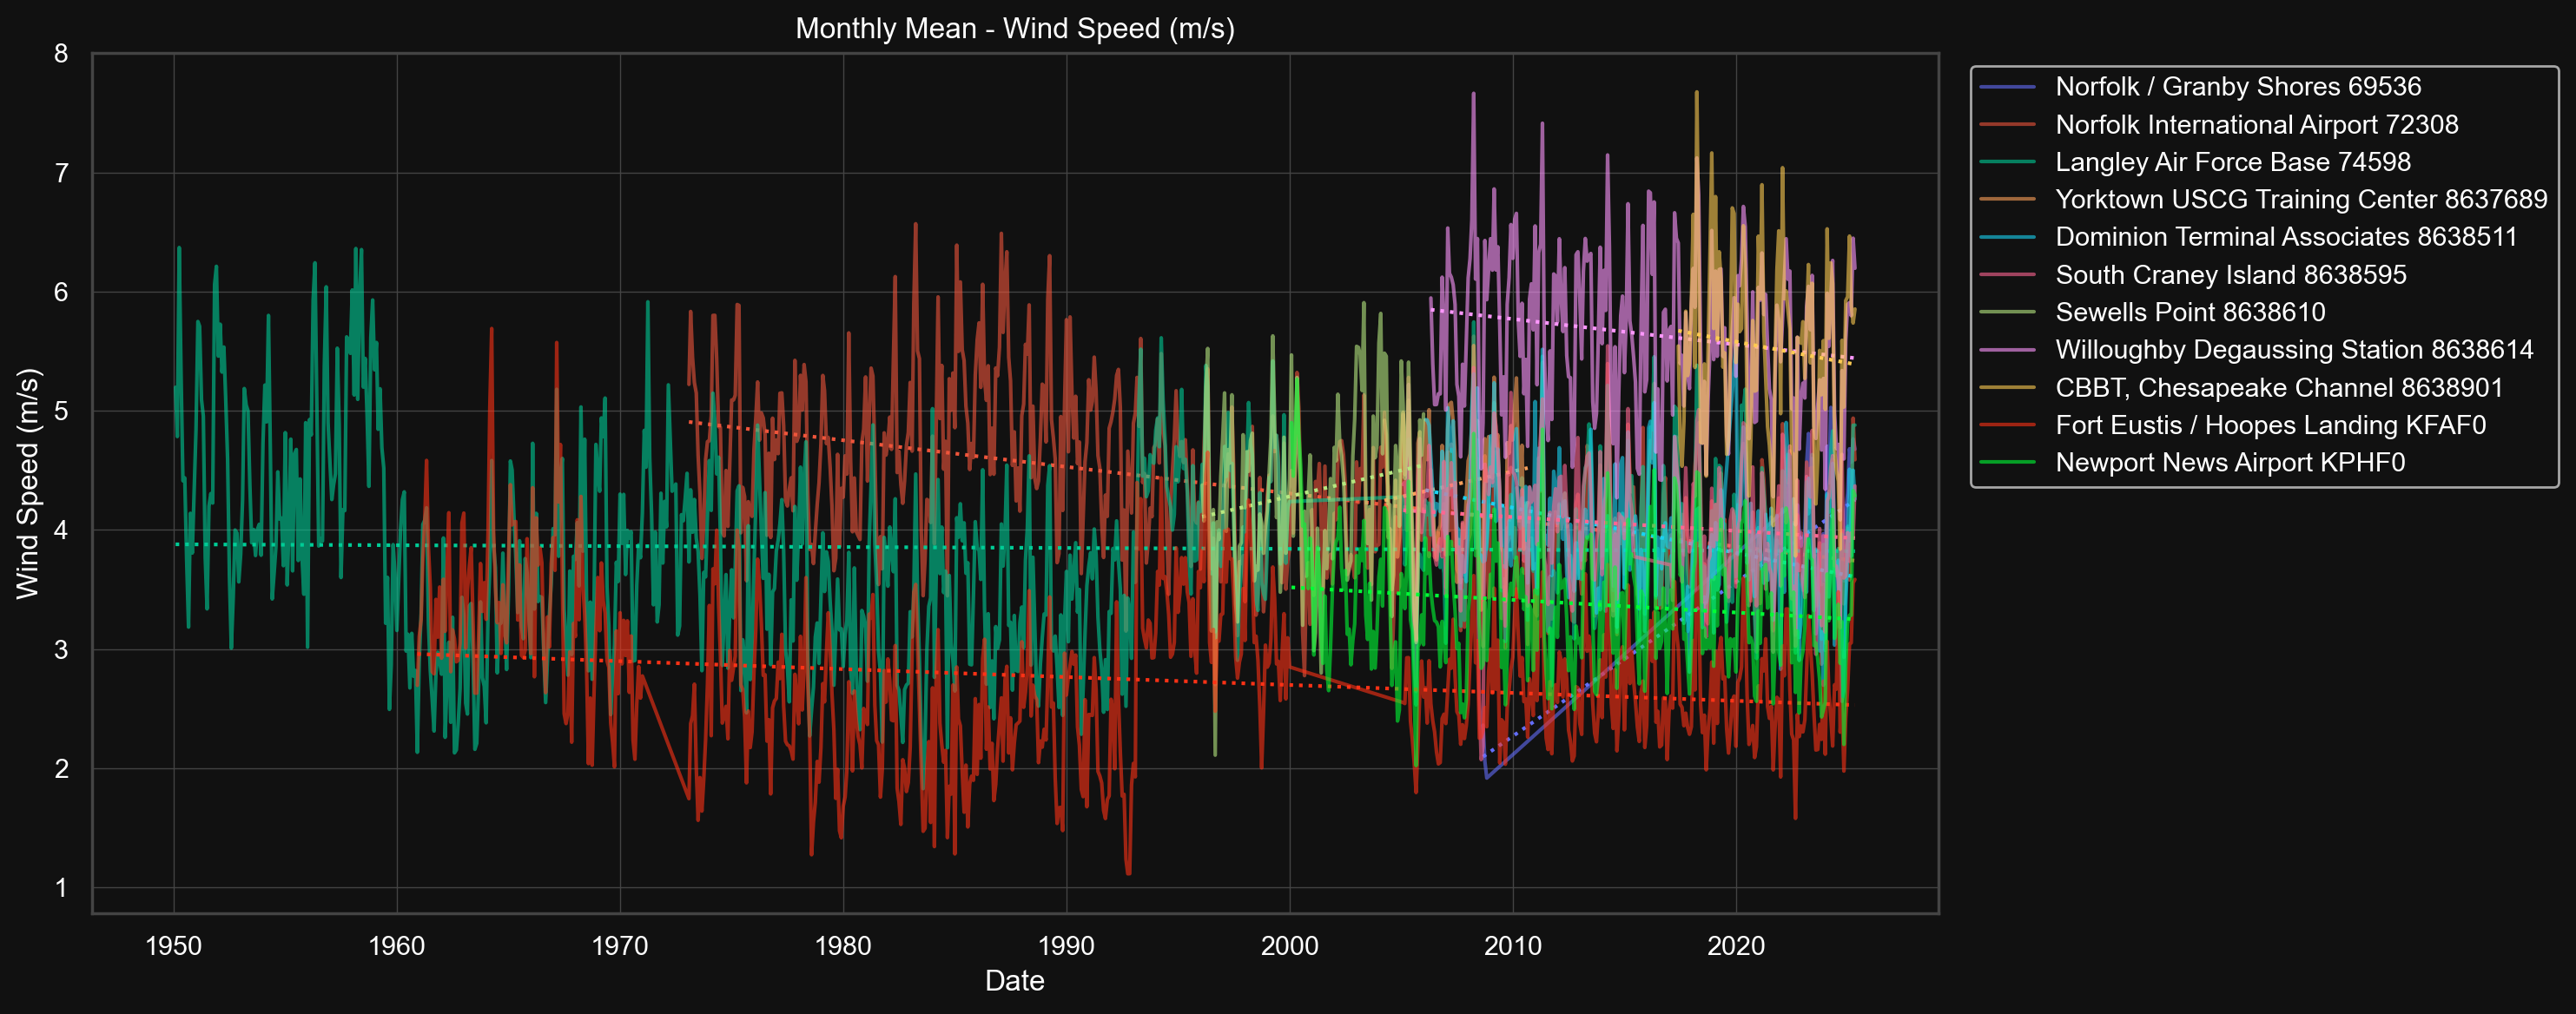

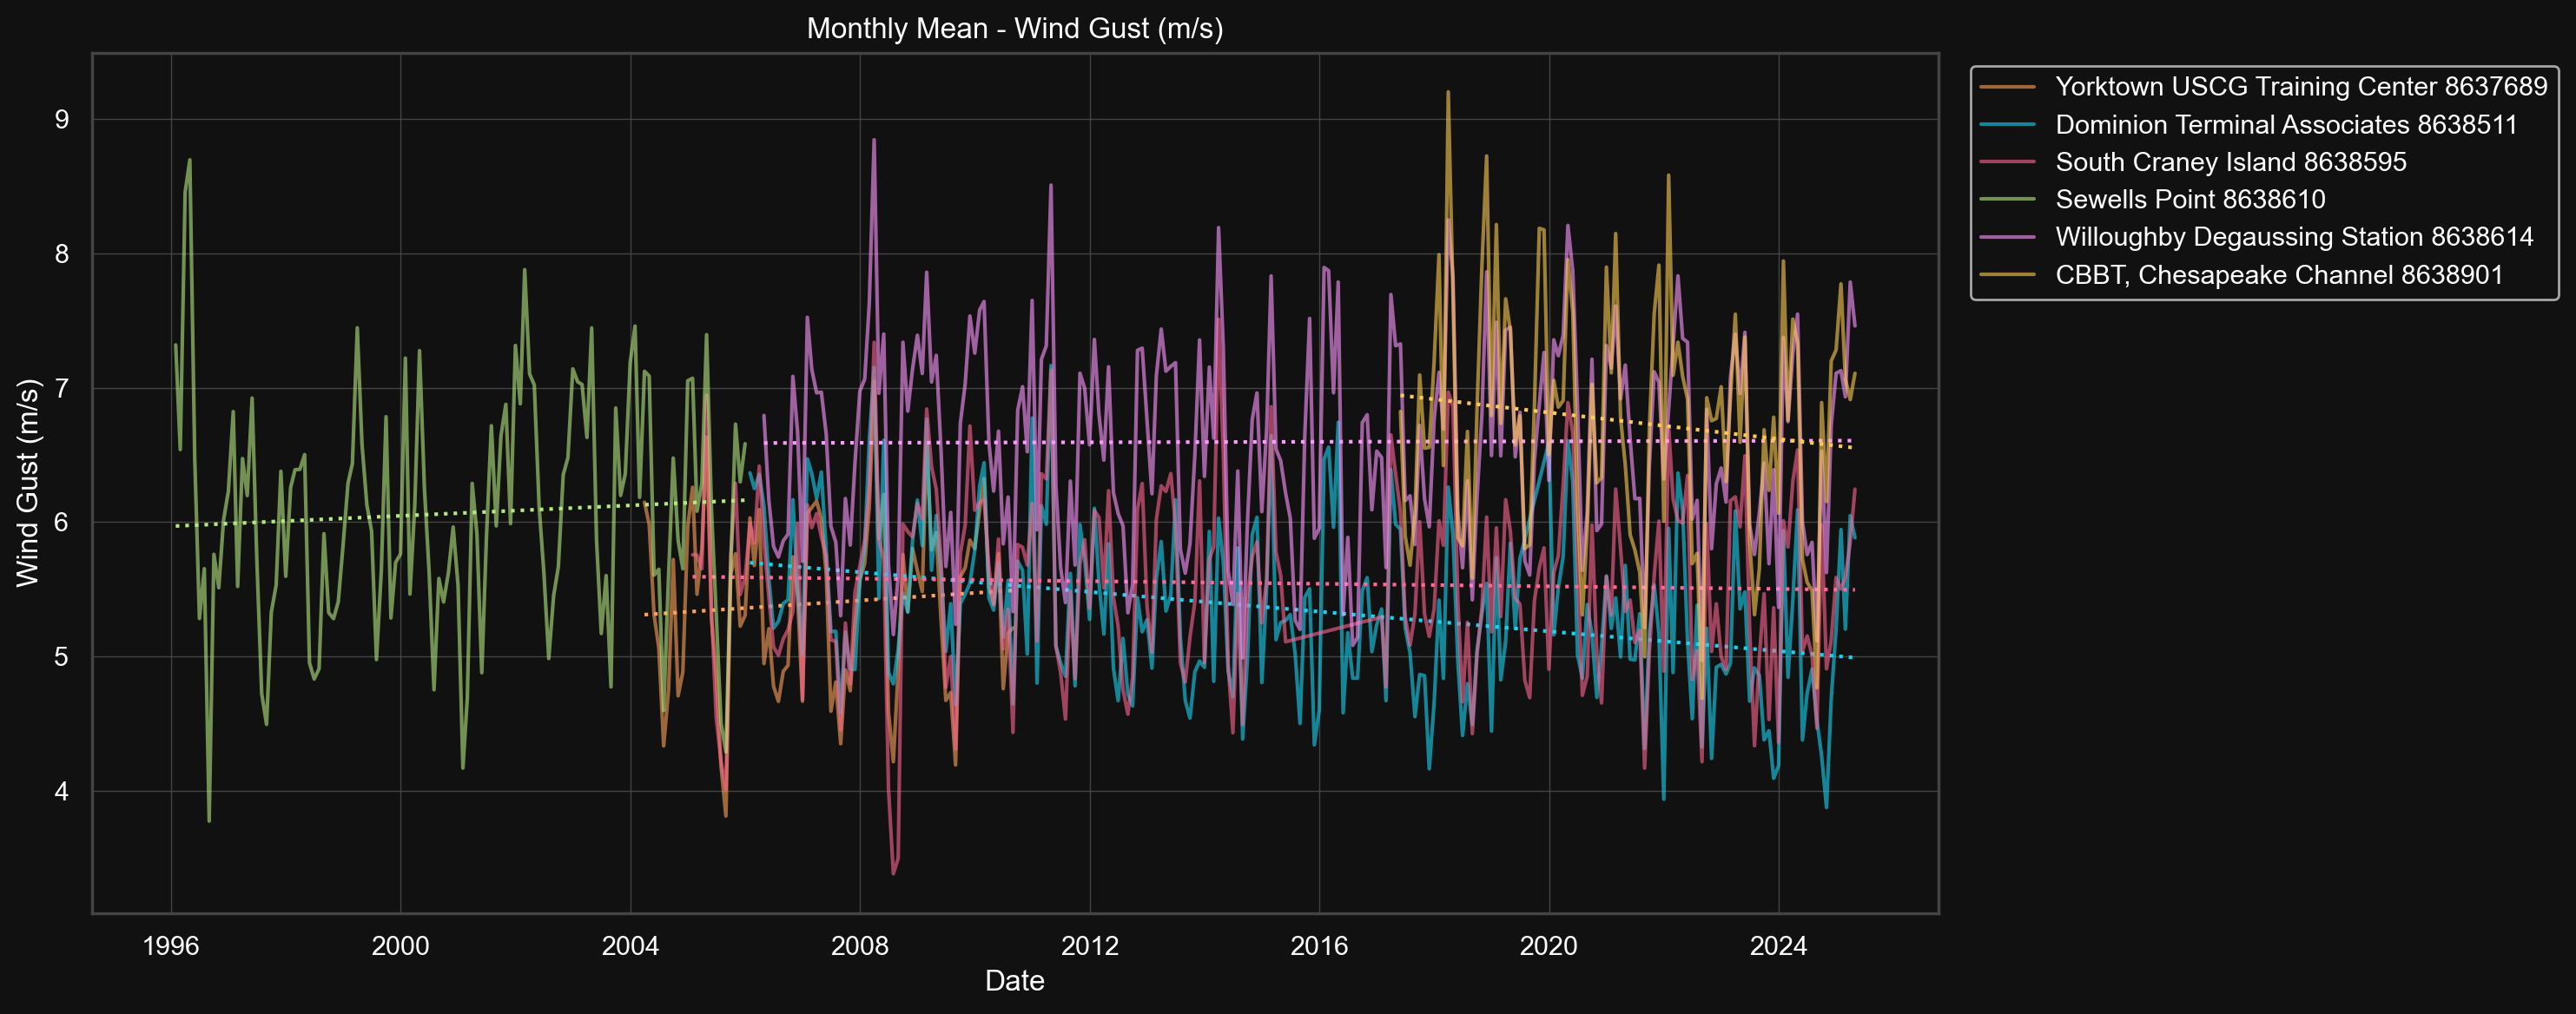

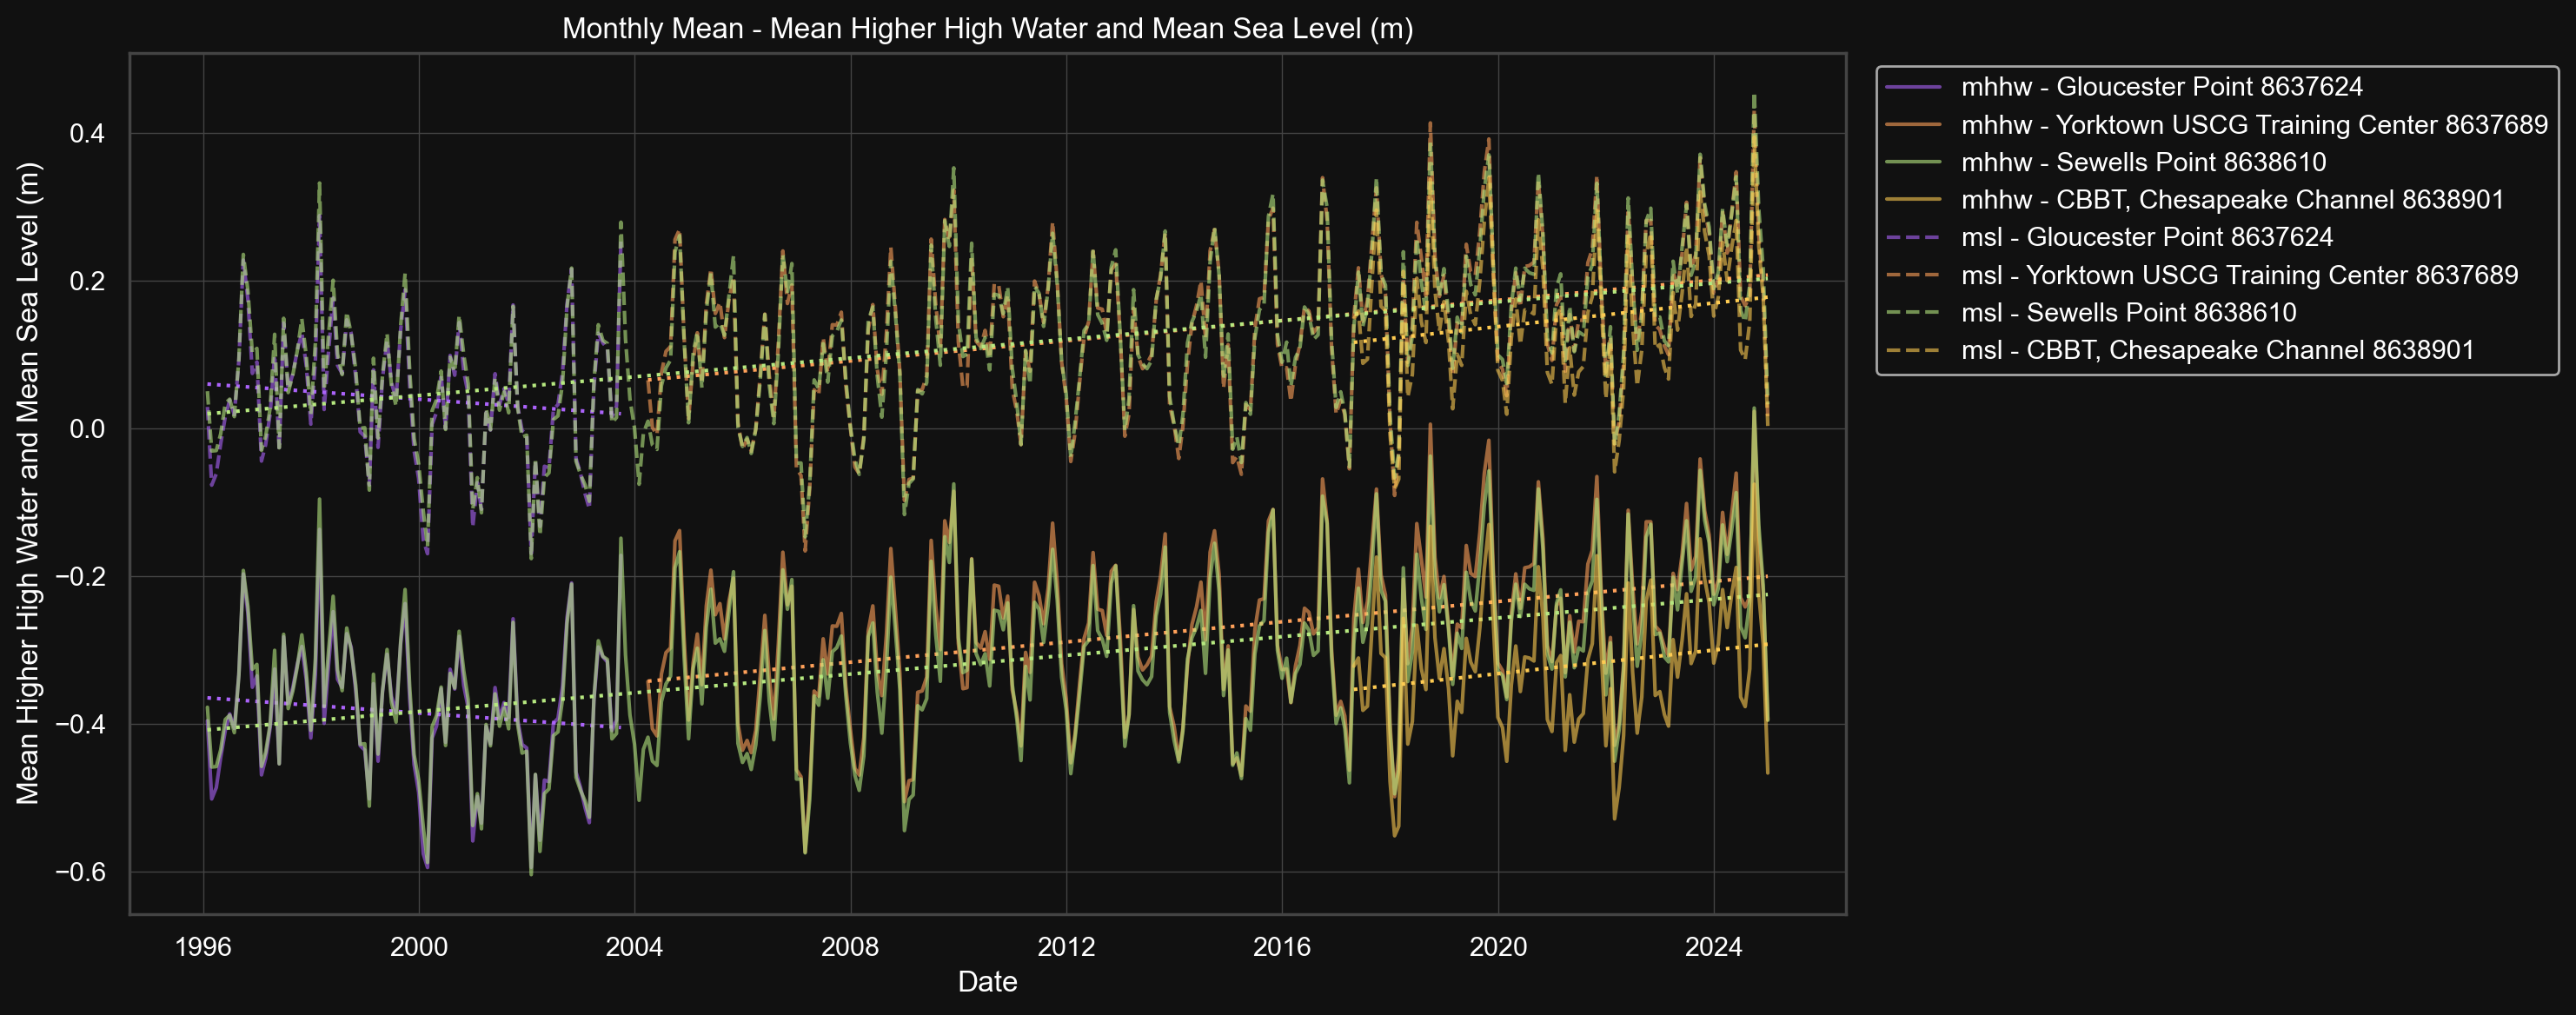

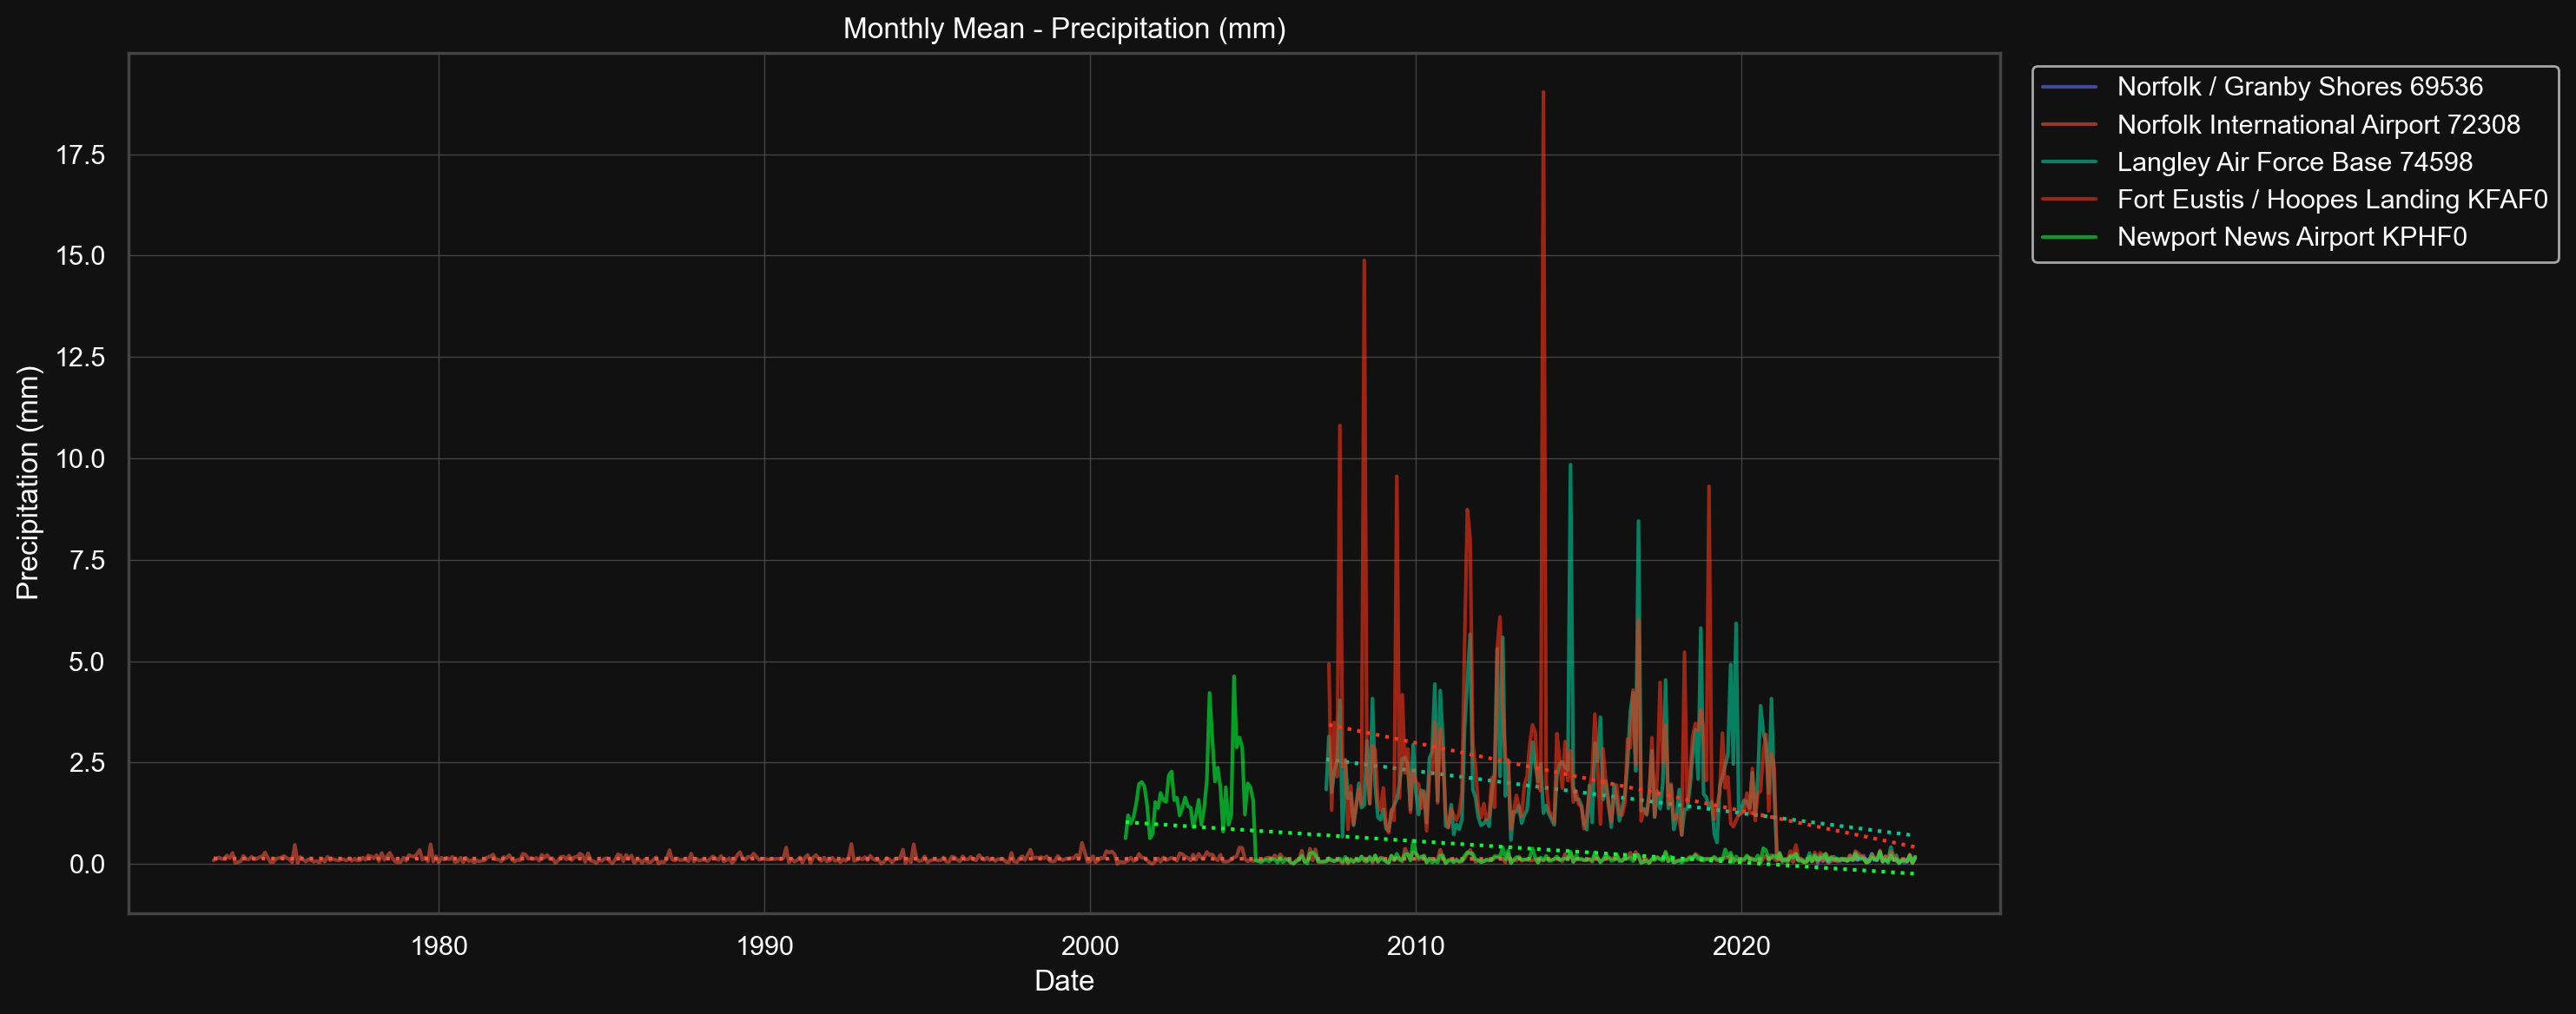

In [7]:
def plot_ts(df, var_regex, label):
    monthly = df.filter(regex=var_regex).resample('ME').mean().dropna(how='all').reset_index()
    plt.figure(figsize=(15, 6))

    prefixes = [col.split('_')[0] for col in monthly.columns[1:]]
    linestyles = ['-', '--', '-.', ':']
    prefix_ls = {p: linestyles[i % len(linestyles)] for i, p in enumerate(sorted(set(prefixes)))}
    
    for col in monthly.columns[1:]:
        prefix, sid = col.split('_')[:2]
        row = colors[colors['id'] == sid]
        color = row.color.iloc[0]
        x = mdates.date2num(monthly['index'])
        y = monthly[col].values
        mask = ~np.isnan(y)

        sns.lineplot(x=monthly['index'], y=y,  color=color, linestyle=prefix_ls[prefix], alpha=0.6,
                     label=f"{prefix} - {row.name.iloc[0]} {sid}" if len(prefix_ls) > 1 else f"{row.name.iloc[0]} {sid}",)
        if mask.any():
            z = np.polyfit(x[mask], y[mask], 1)
            plt.plot(mdates.num2date(x[mask]), np.poly1d(z)(x[mask]), linestyle=':', color=color)

    plt.title(f'Monthly Mean - {label}')
    plt.xlabel('Date')
    plt.ylabel(label)
    plt.grid(True, linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for var in ['speed_', 'gust_', 'mhhw_|msl_', 'pr_']:
    plot_ts(no_cmip_df, var, var_map[var])

## Tides: Daily Box Plot and Time Series
- only significant tides (LL, L, H, HH) were labeled in the noaa dataset (6 minute intervals)
- max/highest tides of the day were extracted from raw data
- tide types are aggregated using the max mode of each day across stations
- still need to check if thresholds change overtime for HH (and H) because boxplot comparison is similar
- in most cases, HH contains higher extremes for mhhw, pr, and speed

In [ ]:
tide_type = (df.filter(regex='type_').dropna(how='all').apply(lambda r: r.dropna().mode().max(), axis=1)
             .replace(tide_map))
filtered = df.loc[tide_type.index].filter(regex='speed_|mhhw_|pr_')

prefixes = sorted({col.split('_')[0] for col in filtered})
suffixes = sorted({col.split('_')[-1] for col in filtered})
color_map = {suf: px.colors.qualitative.Plotly[i % 10] for i, suf in enumerate(suffixes)}
all_groups = [f'{suf}_{t}' for suf in suffixes for t in list(tide_map.values())][::-1]

fig = make_subplots(rows=1, cols=len(prefixes), shared_yaxes=True,
                    subplot_titles=prefixes, horizontal_spacing=0.02)

for i, pre in enumerate(prefixes):
    for col in filter(lambda c: c.startswith(pre + '_'), filtered):
        suf = col[len(pre)+1:]
        sub = filtered[[col]].assign(tide_type=tide_type, station_tide=lambda d: d['tide_type'].radd(f'{suf}_'))
        row = colors[colors['id'] == suf]
        color = row.color.iloc[0]
        for group in all_groups:
            if not (gdata := sub[sub['station_tide'] == group]).empty:
                fig.add_trace(go.Box(x=gdata[col], y=[group] * len(gdata), boxpoints='outliers', 
                                     marker=dict(size=5, color=color), line=dict(width=1, color=color),
                                     showlegend=False, orientation='h'), row=1, col=i+1)            

fig.update_layout(template='plotly_dark', height=10*len(all_groups), width=200*len(prefixes),
    title={'text': 'Comparison by Tides', 'x':0.5,'xanchor': 'center'}, margin=dict(l=60, r=10, t=50, b=50),)
for i, pre in enumerate(prefixes):
    fig.update_xaxes(title_text=pre, row=1, col=i+1)
fig.update_yaxes(title_text='Stations and CMIP6 Models (Tide Type)', row=1, col=1)
for i in range(1, len(prefixes)+1):
    fig.update_yaxes(categoryorder='array', categoryarray=all_groups, row=1, col=i)

display(tide_type.value_counts())
display(Image(pio.to_image(fig, format='png', height=5*len(tide_type.unique())*len(all_groups), 
                            width=500*len(prefixes), scale=3)))  if static else fig.show()

HH    8492
LL     735
L      694
H      671
Name: count, dtype: int64

In [ ]:
ordered_tides = list(tide_map.values())[::-1]
suffixes = sorted({col.split('_')[-1] for col in df.filter(regex='mhhw_|type_').dropna(how='all')})

fig, axes = plt.subplots(len(suffixes), 1, figsize=(16, 4 * len(suffixes)), sharex=True, sharey=True)
if len(suffixes) == 1: axes = [axes]  # Ensure iterable for one subplot

for i, suf in enumerate(suffixes):
    subdf = df[[f'mhhw_{suf}', f'type_{suf}']].dropna().rename(columns={f'mhhw_{suf}': 'mhhw', f'type_{suf}': 'type'})
    subdf['tide_type'] = pd.Categorical(subdf['type'].replace(tide_map), categories=ordered_tides, ordered=True)
    
    ax = axes[i]
    sns.lineplot(data=subdf, x=subdf.index, y='mhhw', hue='tide_type', linewidth=0.8, alpha=0.8, ax=ax)

    for tide in ordered_tides:
        group = subdf[subdf['tide_type'] == tide]
        if not group.empty:
            x, y = mdates.date2num(group.index), group['mhhw'].values
            mask = ~np.isnan(y)
            if mask.any():
                ax.plot(group.index[mask], np.poly1d(np.polyfit(x[mask], y[mask], 1))(x[mask]), linestyle=':',
                        color=ax.get_lines()[ordered_tides.index(tide)].get_color())
    
    ax.set_title(f"Station {suf}", loc='left', fontsize=12)
    ax.grid(True, linewidth=0.5)
    ax.set_ylabel('')
    ax.get_legend().remove()

axes[-1].set_xlabel("Date")
fig.text(0.05, 0.5, 'MHHW', va='center', rotation='vertical', fontsize=14)
fig.suptitle("Daily MHHW Time Series by Tide Types", fontsize=16, y=1.02)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Tide Type", loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4)

plt.tight_layout(rect=[0.06, 0, 0.95, 0.98])
plt.show()


## Wind Rose Chart
- shared bins/legend
- bins only include positive values; (-0.001, x] is exclusive

In [ ]:
# Wind direction mapping
dir_map = {d: i * 22.5 for i, d in enumerate(
    ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'])}

polar = dict(radialaxis=dict(showticklabels=True, ticks=''),
    angularaxis=dict(showticklabels=True, tickmode='array', tickvals=list(dir_map.values()), 
                     ticktext=list(dir_map.keys()), direction='clockwise', rotation=90))

configs = [('speed', 'Wind Speed', px.colors.sequential.dense_r),
           ('diff', 'Wind Gust-Speed Difference', px.colors.sequential.Plotly3)]

# Generate bins for global data
quantiles = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .99, 1]
ss, gg = wind_df.filter(regex='speed_'), wind_df.filter(regex='gust_')
ss.columns, gg.columns = range(ss.shape[1]), range(gg.shape[1])
bins = {v: df.stack().quantile(quantiles).values for df, v in zip([ss, gg - ss], ['speed', 'diff'])}

n = len(wind_stations)
fig = make_subplots(rows=n, cols=2, subplot_titles=[], vertical_spacing=0.02, horizontal_spacing=0.05,
                    specs=[[{'type': 'polar'}, {'type': 'polar'}]] * n,)

for idx, station_id in enumerate(wind_stations):
    row = idx + 1
    info = noaa[noaa.station_id == str(station_id)].iloc[0]
    dd = wind_df.filter(regex=str(station_id)).dropna()
    dd.columns = [c.split('_')[0] for c in dd.columns]
    dd['diff'] = dd['gust'] - dd['speed']
    dd['angle'] = dd['dir'].map(dir_map)

    for v in ['speed', 'diff']:
        dd[f'{v}_bin'] = pd.cut(dd[v], bins[v], include_lowest=True)

    title = f'{info.station_name} {station_id} ({info.start_date.year}–{info.end_date.year})'
    fig.add_annotation(text=title, x=-0.05, y=1 - ((row - 0.5) * (1/n)), showarrow=False, textangle=-90,
                       font=dict(size=12), align='center', xanchor='center', yanchor='middle')
    if row == 1:
        fig.add_annotation(text='Wind Speed', x=0.17, y=1.02, showarrow=False, font=dict(size=20))
        fig.add_annotation(text='Gust-Speed Difference', x=0.90, y=1.02, showarrow=False, font=dict(size=20))
    for i, (v, l, c) in enumerate(configs, start=1):
        grouped = dd.groupby(['angle', f'{v}_bin']).size().reset_index(name='frequency')
        for j, b in enumerate(grouped[f'{v}_bin'].unique()):
            subset = grouped[grouped[f'{v}_bin'] == b]
            fig.add_trace(go.Barpolar(r=subset['frequency'], theta=subset['angle'], name=str(b),
                legendgroup=f'{v}_group_{b}', marker_color=c[j % len(c)], showlegend=(row==1)), row=row, col=i)

fig.update_layout(template='plotly_dark', width=1100, height=2700, title_x=0.5, 
    showlegend=True,legend_title=dict(text="Speed & Gust-Speed Diff"), margin=dict(l=60, r=10, t=60, b=50),
    **{f'polar{i}': polar for i in range(1, 2 * n + 1)})

display(Image(pio.to_image(fig, format='png', width=1100, height=2700, scale=2))) if static else fig.show()

In [ ]:
# plt.figure(figsize=(8, 5)) 
# color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
# for i, station_id in enumerate(wind_stations):
#     diff = (wind_df[f'gust_{station_id}'] - wind_df[f'speed_{station_id}']).dropna()
#     color = color_cycle[i % len(color_cycle)]
#     sns.kdeplot(diff, label=str(station_id), alpha=0.6, color=color)
#     plt.axvline(diff.quantile(0.99), linewidth=0.8, alpha=1, color=color)

# plt.xlabel('Gust - Speed (m/s)')
# plt.ylabel('Density')
# plt.title('Wind Gust-Speed Difference Distribution Across Stations')
# plt.legend(title='Station ID')
# plt.tight_layout()
# plt.show()